# **Notebook: Análise de Dados de Filmes do IMDB e TMDB com Arquitetura Lakehouse**

## **1. Introdução**

Este notebook implementa uma solução de análise de dados utilizando os datasets do IMDB, organizados em uma arquitetura de três camadas (bronze, prata e ouro). O objetivo é estruturar e processar os dados do IMDB em camadas progressivas de refinamento, analisar tendências históricas de gêneros cinematográficos, explorar padrões em avaliações e suas correlações com características dos filmes, identificar colaborações entre diretores e atores, analisar as carreiras de diretores e atores, e analisar características dos títulos dos filmes ao longo do tempo.

**Objetivos:**

- Estruturar e processar dados do IMDB e TMDB em camadas progressivas de refinamento
- Analisar relação entre orçamento e ROI dos filmes
- Analisar evolução de gêneros populares ao longo das décadas

- Analisar a duração dos filmes ao longo do tempo
- Analisar correlação entre avaliação e lucratividade

**Metodologia:**

- Camada Bronze: Dados brutos importados do IMDB e de API do TMDB
- Camada Prata: Dados padronizados, limpos e estruturados
- Camada Ouro: Visões analíticas específicas para responder questões de negócio

**Autor:** Victor Carlos Teixeira da Costa
**Data:** Abril de 2025

## **1. Configuração do Ambiente no Microsoft Fabric**

Nesta etapa, serão importadas as bibliotecas necessárias e configurado o ambiente Spark para otimizar o desempenho.

In [5]:
# Célula de importação das bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import json
import io
import gzip
import os

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 7, Finished, Available, Finished)

In [6]:
# Verificação da versão do Spark e configurações iniciais
print(f"Versão do Spark: {spark.version}")

# Configuração do Spark para melhor desempenho
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
spark.conf.set("spark.sql.shuffle.partitions", "200")

# Definição do caminho base do Lakehouse
lakehouse_path = "abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files"

# Definição dos caminhos para as camadas no Lakehouse
bronze_path = f"{lakehouse_path}/bronze"
silver_path = f"{lakehouse_path}/silver"
gold_path = f"{lakehouse_path}/gold"

# Chave da API do TMDB
tmdb_api_key = "8d58003a390d2ce1791c1a6e6d8e3fef" 

print(f"Caminho da camada Bronze: {bronze_path}")
print(f"Caminho da camada Prata: {silver_path}")
print(f"Caminho da camada Ouro: {gold_path}")
print("Ambiente configurado com sucesso!")

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 8, Finished, Available, Finished)

Versão do Spark: 3.5.1.5.4.20250211.1
Caminho da camada Bronze: abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/bronze
Caminho da camada Prata: abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/silver
Caminho da camada Ouro: abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/gold
Ambiente configurado com sucesso!


*Comentários:*
- A configuração do Spark é crucial para o desempenho. A otimização adaptativa e o número de partições shuffle são ajustados para lidar com grandes volumes de dados de forma eficiente.
- Em um ambiente de produção, a chave API do TMDB deveria estar armazenada de forma segura.

# **2. Camada Bronze: Ingestão de Dados**

## **2.1 Conexão com API e Ingestão de Datasets**

In [7]:
# Função para baixar e salvar datasets do IMDB diretamente no Lakehouse
def download_imdb_datasets_to_lakehouse():
    imdb_datasets = {
        "title.basics": "https://datasets.imdbws.com/title.basics.tsv.gz",
        "title.ratings": "https://datasets.imdbws.com/title.ratings.tsv.gz",
        "title.crew": "https://datasets.imdbws.com/title.crew.tsv.gz",
        "name.basics": "https://datasets.imdbws.com/name.basics.tsv.gz"
    }
    
    for dataset_name, url in imdb_datasets.items():
        print(f"Baixando {dataset_name} do IMDb...")
        
        try:
            # Requisição para baixar o arquivo
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Verifica se houve erro na requisição
            
            # Leitura do conteúdo do arquivo gzip diretamente para um DataFrame
            # Descompactação do conteúdo
            with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gzipped:
                # Conversão para um DataFrame Pandas
                pd_df = pd.read_csv(gzipped, sep='\t', low_memory=False)
                
                # Conversão para DataFrame Spark
                spark_df = spark.createDataFrame(pd_df)
                
                # Salva como Delta no Lakehouse
                target_path = f"{bronze_path}/imdb/{dataset_name}"
                spark_df.write.format("delta").mode("overwrite").save(target_path)
                
                # Registro em uma tabela temporária
                table_name = f"bronze_imdb_{dataset_name.replace('.', '_')}"
                spark_df.createOrReplaceTempView(table_name)
                
                print(f"Dataset {dataset_name} salvo com sucesso em {target_path}")
                print(f"Número de registros: {spark_df.count()}")
                
        except Exception as e:
            print(f"Erro ao baixar ou processar {dataset_name}: {str(e)}")
    
    print("Download dos datasets do IMDb concluído!")

# Função para obter dados da API do TMDB e salvá-los no Lakehouse
def fetch_tmdb_data_to_lakehouse():
    print("Obtendo dados da API do TMDB...")
    
    # URL da API do TMDB
    base_url = "https://api.themoviedb.org/3"
    
    try:
        # 1. Obter filmes populares
        popular_movies = []
        total_pages = 20  # Limitação a 20 páginas para obter um conjunto de dados razoável
        
        for page in range(1, total_pages + 1):
            url = f"{base_url}/movie/popular?api_key={tmdb_api_key}&language=pt-BR&page={page}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            popular_movies.extend(data['results'])
            print(f"Página {page}/{total_pages} de filmes populares obtida.")
        
        # Criação de DataFrame de filmes populares
        movies_data = []
        for movie in popular_movies:
            movies_data.append({
                "id": movie.get("id"),
                "title": movie.get("title"),
                "original_title": movie.get("original_title"),
                "release_date": movie.get("release_date"),
                "popularity": movie.get("popularity"),
                "vote_average": movie.get("vote_average"),
                "vote_count": movie.get("vote_count"),
                "overview": movie.get("overview"),
                "poster_path": movie.get("poster_path"),
                "backdrop_path": movie.get("backdrop_path"),
                "original_language": movie.get("original_language"),
                "genre_ids": str(movie.get("genre_ids", []))
            })
        
        # Conversão para DataFrame Spark
        movies_schema = StructType([
            StructField("id", IntegerType(), True),
            StructField("title", StringType(), True),
            StructField("original_title", StringType(), True),
            StructField("release_date", StringType(), True),
            StructField("popularity", FloatType(), True),
            StructField("vote_average", FloatType(), True),
            StructField("vote_count", IntegerType(), True),
            StructField("overview", StringType(), True),
            StructField("poster_path", StringType(), True),
            StructField("backdrop_path", StringType(), True),
            StructField("original_language", StringType(), True),
            StructField("genre_ids", StringType(), True)
        ])
        
        movies_df = spark.createDataFrame(movies_data, movies_schema)
        
        # Salvar como Delta no Lakehouse
        movies_df.write.format("delta").mode("overwrite").save(f"{bronze_path}/tmdb/movies")
        movies_df.createOrReplaceTempView("bronze_tmdb_movies")
        
        print(f"Dados de {len(movies_data)} filmes populares salvos no Lakehouse")
        
        # 2. Obter detalhes dos filmes (incluindo orçamento, receita, etc.)
        detailed_movies = []
        movie_ids = [movie["id"] for movie in movies_data]
        
        # Limitação a 100 filmes para não exceder limites da API
        for i, movie_id in enumerate(movie_ids[:100]):
            try:
                url = f"{base_url}/movie/{movie_id}?api_key={tmdb_api_key}&language=pt-BR"
                response = requests.get(url)
                response.raise_for_status()
                movie_details = response.json()
                
                # Campos adicionais
                detailed_movies.append({
                    "id": movie_details.get("id"),
                    "budget": movie_details.get("budget"),
                    "revenue": movie_details.get("revenue"),
                    "runtime": movie_details.get("runtime"),
                    "status": movie_details.get("status"),
                    "tagline": movie_details.get("tagline"),
                    "genres": json.dumps([g.get("name") for g in movie_details.get("genres", [])]),
                    "production_companies": json.dumps([c.get("name") for c in movie_details.get("production_companies", [])]),
                    "production_countries": json.dumps([c.get("name") for c in movie_details.get("production_countries", [])])
                })
                
                if (i + 1) % 10 == 0:
                    print(f"Detalhes obtidos para {i + 1}/{len(movie_ids[:100])} filmes")
                    
            except Exception as e:
                print(f"Erro ao obter detalhes do filme {movie_id}: {str(e)}")
        
        # Conversão para DataFrame Spark
        details_schema = StructType([
            StructField("id", IntegerType(), True),
            StructField("budget", LongType(), True),
            StructField("revenue", LongType(), True),
            StructField("runtime", IntegerType(), True),
            StructField("status", StringType(), True),
            StructField("tagline", StringType(), True),
            StructField("genres", StringType(), True),
            StructField("production_companies", StringType(), True),
            StructField("production_countries", StringType(), True)
        ])
        
        details_df = spark.createDataFrame(detailed_movies, details_schema)
        
        # Salvar como Delta no Lakehouse
        details_df.write.format("delta").mode("overwrite").save(f"{bronze_path}/tmdb/movie_details")
        details_df.createOrReplaceTempView("bronze_tmdb_movie_details")
        
        print(f"Detalhes de {len(detailed_movies)} filmes salvos no Lakehouse")
        
        # 3. Obter créditos (elenco e equipe)
        movie_credits = []
        
        for i, movie_id in enumerate(movie_ids[:100]):
            try:
                url = f"{base_url}/movie/{movie_id}/credits?api_key={tmdb_api_key}&language=pt-BR"
                response = requests.get(url)
                response.raise_for_status()
                credits = response.json()
                
                # Adicionar créditos
                movie_credits.append({
                    "movie_id": movie_id,
                    "cast": json.dumps(credits.get("cast", [])[:10]),  # Limitar aos 10 primeiros atores
                    "crew": json.dumps([c for c in credits.get("crew", []) if c.get("job") == "Director"])  # Apenas diretores
                })
                
                if (i + 1) % 10 == 0:
                    print(f"Créditos obtidos para {i + 1}/{len(movie_ids[:100])} filmes")
                    
            except Exception as e:
                print(f"Erro ao obter créditos do filme {movie_id}: {str(e)}")
        
        # Convertesão para DataFrame Spark
        credits_schema = StructType([
            StructField("movie_id", IntegerType(), True),
            StructField("cast", StringType(), True),
            StructField("crew", StringType(), True)
        ])
        
        credits_df = spark.createDataFrame(movie_credits, credits_schema)
        
        # Salvar como Delta no Lakehouse
        credits_df.write.format("delta").mode("overwrite").save(f"{bronze_path}/tmdb/movie_credits")
        credits_df.createOrReplaceTempView("bronze_tmdb_movie_credits")
        
        print(f"Créditos de {len(movie_credits)} filmes salvos no Lakehouse")
        
        # 4. Obter lista de gêneros para referência
        try:
            url = f"{base_url}/genre/movie/list?api_key={tmdb_api_key}&language=pt-BR"
            response = requests.get(url)
            response.raise_for_status()
            genres_data = response.json()["genres"]
            
            # Criar DataFrame de gêneros
            genres_df = spark.createDataFrame(genres_data)
            
            # Salvar como Delta no Lakehouse
            genres_df.write.format("delta").mode("overwrite").save(f"{bronze_path}/tmdb/genres")
            genres_df.createOrReplaceTempView("bronze_tmdb_genres")
            
            print(f"Lista de {len(genres_data)} gêneros de filmes salva no Lakehouse")
        except Exception as e:
            print(f"Erro ao obter lista de gêneros: {str(e)}")
        
        print("Dados da API do TMDB obtidos e salvos com sucesso!")
        
    except Exception as e:
        print(f"Erro ao obter dados da API do TMDB: {str(e)}")
        print("Verifique se sua chave de API é válida e se você tem conexão com a internet.")

# Execução das funções de download e ingestão de dados
print("Iniciando ingestão de dados na camada Bronze...")

# Baixar e salvar datasets do IMDb
download_imdb_datasets_to_lakehouse()

# Obter dados da API do TMDB
fetch_tmdb_data_to_lakehouse()

print("Ingestão de dados na camada Bronze concluída!")

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 9, Finished, Available, Finished)

Iniciando ingestão de dados na camada Bronze...
Baixando title.basics do IMDb...
Dataset title.basics salvo com sucesso em abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/bronze/imdb/title.basics
Número de registros: 11582329
Baixando title.ratings do IMDb...
Dataset title.ratings salvo com sucesso em abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/bronze/imdb/title.ratings
Número de registros: 1557387
Baixando title.crew do IMDb...
Dataset title.crew salvo com sucesso em abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/bronze/imdb/title.crew
Número de registros: 11584668
Baixando name.basics do IMDb...
Dataset name.basics salvo com sucesso em abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/bronze/im

*Comentários:*

- A função `download_imdb_datasets_to_lakehouse` baixa os datasets do IMDB, descompacta e salva como Delta tables no Lakehouse.
- A função `fetch_tmdb_data_to_lakehouse` coleta dados da API do TMDB, incluindo filmes populares, detalhes e créditos, e também salva como Delta tables.
- A limitação do número de páginas e filmes na API do TMDB é importante para evitar exceder os limites da API.

## **2.2 Verificação dos Dados Brutos no Lakehouse**

In [8]:
# Verificação dos dados carregados na camada Bronze
def verify_bronze_data():
    print("\n=== Verificação dos Dados na Camada Bronze ===")
    
    # Verificação dos dados do IMDb
    print("\nVerificando dados do IMDb:")
    try:
        # Tentativa de ler os dados do IMDb da camada Bronze
        imdb_datasets = ["title.basics", "title.ratings", "title.crew", "name.basics"]
        for dataset in imdb_datasets:
            try:
                df = spark.read.format("delta").load(f"{bronze_path}/imdb/{dataset}")
                print(f"  - IMDb {dataset}: {df.count()} registros")
                # Apresentar amostra
                if dataset == "title.basics":
                    print("\nAmostra de dados IMDb (title.basics):")
                    df.select("tconst", "primaryTitle", "startYear", "genres").show(3, truncate=False)
            except Exception as e:
                print(f"  - IMDb {dataset}: Não disponível ou erro ao ler ({str(e)})")
    except Exception as e:
        print(f"Erro ao verificar dados do IMDb: {str(e)}")
    
    # Verificação dos dados do TMDB
    print("\nVerificando dados do TMDB:")
    try:
        # Tentativa de ler os dados do TMDB da camada Bronze
        tmdb_datasets = ["movies", "movie_details", "movie_credits", "genres"]
        for dataset in tmdb_datasets:
            try:
                df = spark.read.format("delta").load(f"{bronze_path}/tmdb/{dataset}")
                print(f"  - TMDB {dataset}: {df.count()} registros")
                # Mostrar amostra
                if dataset == "movies":
                    print("\nAmostra de dados TMDB (movies):")
                    df.select("id", "title", "release_date", "vote_average").show(3, truncate=False)
            except Exception as e:
                print(f"  - TMDB {dataset}: Não disponível ou erro ao ler ({str(e)})")
    except Exception as e:
        print(f"Erro ao verificar dados do TMDB: {str(e)}")
    
    print("\nVerificação dos dados na camada Bronze concluída!")

# Executar verificação
verify_bronze_data()

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 10, Finished, Available, Finished)


=== Verificação dos Dados na Camada Bronze ===

Verificando dados do IMDb:
  - IMDb title.basics: 11582329 registros

Amostra de dados IMDb (title.basics):
+---------+------------------+---------+-----------------------+
|tconst   |primaryTitle      |startYear|genres                 |
+---------+------------------+---------+-----------------------+
|tt3097576|Oh Brother        |2013     |Action,Animation,Comedy|
|tt3097578|You or a Loved One|2014     |Comedy,Drama           |
|tt3097580|Kick It Up a Notch|2012     |Action,Animation,Comedy|
+---------+------------------+---------+-----------------------+
only showing top 3 rows

  - IMDb title.ratings: 1557387 registros
  - IMDb title.crew: 11584668 registros
  - IMDb name.basics: 14327946 registros

Verificando dados do TMDB:
  - TMDB movies: 400 registros

Amostra de dados TMDB (movies):
+------+---------------------------+------------+------------+
|id    |title                      |release_date|vote_average|
+------+--------------

*Comentários:*

- A função `verify_bronze_data` verifica se os dados foram carregados corretamente na camada Bronze, exibindo o número de registros e uma amostra dos dados.

# **3. Camada Prata: Limpeza e Transformação**

## **3.1 Limpeza e Transformação dos Dados IMDB**

In [9]:
# Processamento dos dados IMDB para a camada Prata
def process_imdb_to_silver():
    print("\nProcessando dados do IMDb para a camada Prata...")
    
    try:
        # Carregamento dos dados do IMDb da camada Bronze
        imdb_movies = spark.read.format("delta").load(f"{bronze_path}/imdb/title.basics")
        imdb_ratings = spark.read.format("delta").load(f"{bronze_path}/imdb/title.ratings")
        
        # Registro como tabelas temporárias para uso com SQL
        imdb_movies.createOrReplaceTempView("bronze_imdb_title_basics")
        imdb_ratings.createOrReplaceTempView("bronze_imdb_title_ratings")
        
        # Filtro de apenas filmes (excluir séries, etc.)
        silver_imdb_movies = spark.sql(r"""
            SELECT 
                tconst AS imdb_id,
                primaryTitle AS title,
                originalTitle AS original_title,
                CAST(NULLIF(startYear, '\N') AS INT) AS release_year,
                CAST(NULLIF(runtimeMinutes, '\N') AS INT) AS runtime_minutes,
                genres
            FROM bronze_imdb_title_basics
            WHERE titleType = 'movie'
              AND startYear IS NOT NULL
              AND startYear != '\N'
              AND CAST(startYear AS INT) > 1900
        """)
        
        # Processamento das avaliações
        silver_imdb_ratings = spark.sql("""
            SELECT
                tconst AS imdb_id,
                CAST(averageRating AS FLOAT) AS average_rating,
                CAST(numVotes AS INT) AS num_votes
            FROM bronze_imdb_title_ratings
        """)
        
        # Unificação dos filmes com avaliações
        silver_imdb = silver_imdb_movies.join(
            silver_imdb_ratings,
            silver_imdb_movies.imdb_id == silver_imdb_ratings.imdb_id,
            "left"
        ).select(
            silver_imdb_movies["*"],
            silver_imdb_ratings["average_rating"],
            silver_imdb_ratings["num_votes"]
        )
        
        # Processamento dos gêneros para formato explodido
        silver_imdb_with_genres = silver_imdb.withColumn(
            "genre_array", F.split(F.col("genres"), ",")
        ).withColumn(
            "genre", F.explode(F.col("genre_array"))
        ).drop("genre_array", "genres")
        
        # Salvamento na camada prata
        silver_imdb.write.format("delta").mode("overwrite").save(f"{silver_path}/imdb_movies")
        silver_imdb_with_genres.write.format("delta").mode("overwrite").save(f"{silver_path}/imdb_movies_by_genre")
        
        # Registro como views para acesso SQL
        silver_imdb.createOrReplaceTempView("silver_imdb_movies")
        silver_imdb_with_genres.createOrReplaceTempView("silver_imdb_movies_by_genre")
        
        print(f"Dados IMDb processados e salvos na camada Prata: {silver_path}")
        print(f"  - IMDb filmes: {silver_imdb.count()} registros")
        print(f"  - IMDb filmes por gênero: {silver_imdb_with_genres.count()} registros")
        
        return silver_imdb, silver_imdb_with_genres
        
    except Exception as e:
        print(f"Erro ao processar dados IMDb para a camada Prata: {str(e)}")
        
        # Criação de DataFrames vazios para continuar o notebook
        empty_schema = StructType([
            StructField("imdb_id", StringType(), True),
            StructField("title", StringType(), True),
            StructField("release_year", IntegerType(), True)
        ])
        
        empty_df = spark.createDataFrame([], empty_schema)
        empty_df.createOrReplaceTempView("silver_imdb_movies")
        empty_df.createOrReplaceTempView("silver_imdb_movies_by_genre")
        
        return empty_df, empty_df

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 11, Finished, Available, Finished)


Processando dados do IMDb para a camada Prata...
Dados IMDb processados e salvos na camada Prata: abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/silver
  - IMDb filmes: 607050 registros
  - IMDb filmes por gênero: 903948 registros

Processando dados do TMDB para a camada Prata...
Dados TMDB processados e salvos na camada Prata: abfss://3700c2ba-3cba-44f9-921d-ea0ec451a3c7@onelake.dfs.fabric.microsoft.com/91027fb5-da19-4445-a72b-ab7ec8734eed/Files/silver/tmdb_movies
  - TMDB filmes: 400 registros

=== Estatísticas dos Dados Transformados (Camada Prata) ===
IMDB Filmes (Prata): 607050 registros
TMDB Filmes (Prata): 400 registros

Amostra de dados IMDB (Prata):
+----------+------------------+------------------+------------+---------------+--------------------+--------------+---------+
|   imdb_id|             title|    original_title|release_year|runtime_minutes|              genres|average_rating|num_votes|
+-----

*Comentários:*

- A função `process_imdb_to_silver` carrega os dados do IMDB da camada Bronze, filtra apenas os filmes, processa as avaliações e explode os gêneros.

## **3.2 Limpeza e Transformação dos Dados TMDB**

In [ ]:
# Limpeza e transformação dos dados TMDB
def process_tmdb_to_silver():
    print("\nProcessando dados do TMDB para a camada Prata...")
    
    try:
        # Carregamento dos dados do TMDB da camada Bronze
        tmdb_movies = spark.read.format("delta").load(f"{bronze_path}/tmdb/movies")
        
        # Tentativa de carregar detalhes e créditos, se disponíveis
        try:
            tmdb_details = spark.read.format("delta").load(f"{bronze_path}/tmdb/movie_details")
            has_details = True
        except:
            has_details = False
            print("Detalhes dos filmes TMDB não encontrados, continuando apenas com dados básicos.")
            
        try:
            tmdb_credits = spark.read.format("delta").load(f"{bronze_path}/tmdb/movie_credits")
            has_credits = True
        except:
            has_credits = False
            print("Créditos dos filmes TMDB não encontrados, continuando sem dados de elenco e equipe.")
        
        # Registro como tabelas temporárias
        tmdb_movies.createOrReplaceTempView("bronze_tmdb_movies")
        if has_details:
            tmdb_details.createOrReplaceTempView("bronze_tmdb_movie_details")
        if has_credits:
            tmdb_credits.createOrReplaceTempView("bronze_tmdb_movie_credits")
        
        # Extraição de informações principais
        if has_details:
            # Juntar com detalhes
            silver_tmdb = spark.sql("""
                SELECT
                    m.id AS tmdb_id,
                    m.title,
                    m.original_title,
                    CAST(SUBSTRING(m.release_date, 1, 4) AS INT) AS release_year,
                    d.runtime AS runtime_minutes,
                    d.budget,
                    d.revenue,
                    m.popularity,
                    m.vote_average,
                    m.vote_count,
                    m.overview,
                    d.genres AS tmdb_genres,
                    d.production_companies,
                    d.production_countries
                FROM bronze_tmdb_movies m
                LEFT JOIN bronze_tmdb_movie_details d ON m.id = d.id
                WHERE m.release_date IS NOT NULL
            """)
        else:
            # Uso de apenas dados básicos
            silver_tmdb = spark.sql("""
                SELECT
                    id AS tmdb_id,
                    title,
                    original_title,
                    CAST(SUBSTRING(release_date, 1, 4) AS INT) AS release_year,
                    NULL AS runtime_minutes,
                    NULL AS budget,
                    NULL AS revenue,
                    popularity,
                    vote_average,
                    vote_count,
                    overview,
                    genre_ids AS tmdb_genres,
                    NULL AS production_companies,
                    NULL AS production_countries
                FROM bronze_tmdb_movies
                WHERE release_date IS NOT NULL
            """)
        
        # Juntar com créditos, se disponíveis
        if has_credits:
            silver_tmdb_credits = spark.sql("""
                SELECT
                    movie_id AS tmdb_id,
                    cast,
                    crew
                FROM bronze_tmdb_movie_credits
            """)
            
            # Juntar com informações de créditos
            silver_tmdb = silver_tmdb.join(
                silver_tmdb_credits,
                silver_tmdb.tmdb_id == silver_tmdb_credits.tmdb_id,
                "left"
            ).select(
                silver_tmdb["*"],
                silver_tmdb_credits["cast"],
                silver_tmdb_credits["crew"]
            )
        
        # Salvamento na camada prata
        silver_tmdb.write.format("delta").mode("overwrite").save(f"{silver_path}/tmdb_movies")
        
        # Criação da visão temporária
        silver_tmdb.createOrReplaceTempView("silver_tmdb_movies")
        
        print(f"Dados TMDB processados e salvos na camada Prata: {silver_path}/tmdb_movies")
        print(f"  - TMDB filmes: {silver_tmdb.count()} registros")
        
        return silver_tmdb
    except Exception as e:
        print(f"⚠️ Erro ao processar dados TMDB: {str(e)}")
        # Criação de DataFrame vazio para continuar o notebook
        empty_schema = StructType([StructField("tmdb_id", IntegerType(), True)])
        empty_df = spark.createDataFrame([], empty_schema)
        empty_df.createOrReplaceTempView("silver_tmdb_movies")
        return empty_df

*Comentários:* 
- A função `process_tmdb_to_silver` carrega os dados do TMDB da camada Bronze, extrai informações principais e junta com detalhes e créditos, se disponíveis.

## **3.3 Execução das Transformações e Exibição de Estatísticas**

In [ ]:
# Executar transformações
silver_imdb, silver_imdb_by_genre = process_imdb_to_silver()
silver_tmdb = process_tmdb_to_silver()

# Exibir estatísticas da camada prata
print("\n=== Estatísticas dos Dados Transformados (Camada Prata) ===")
print(f"IMDB Filmes (Prata): {silver_imdb.count()} registros")
print(f"TMDB Filmes (Prata): {silver_tmdb.count()} registros")

# Amostra dos dados
print("\nAmostra de dados IMDB (Prata):")
silver_imdb.show(5)
print("\nAmostra de dados TMDB (Prata):")
silver_tmdb.show(5)

*Comentários:*

- A função `process_imdb_to_silver` carrega os dados do IMDB da camada Bronze, filtra apenas os filmes, processa as avaliações e explode os gêneros.

## **3.4 Construção da Camada Prata Unificada**

In [10]:
# Criação de uma visão unificada dos dados de filmes
def create_unified_silver_layer():
    print("\nCriando camada Prata unificada...")
    
    try:
        # União dos dados do IMDB e TMDB onde possível
        # Nota: Para um caso real, deveria ter uma tabela de mapeamento entre IMDB ID e TMDB ID
        # Para este MVP, usarei uma junção aproximada por título e ano
        
        unified_movies = spark.sql(r"""
            SELECT
                i.imdb_id,
                t.tmdb_id,
                COALESCE(t.title, i.title) AS title,
                COALESCE(t.original_title, i.original_title) AS original_title,
                COALESCE(t.release_year, i.release_year) AS release_year,
                COALESCE(t.runtime_minutes, i.runtime_minutes) AS runtime_minutes,
                t.budget,
                t.revenue,
                t.popularity,
                COALESCE(t.vote_average, i.average_rating) AS rating,
                COALESCE(t.vote_count, i.num_votes) AS vote_count,
                t.overview,
                -- Campos adicionais do TMDB, se disponíveis
                t.tmdb_genres,
                t.production_companies,
                t.production_countries,
                t.cast,
                t.crew
            FROM silver_imdb_movies i
            FULL OUTER JOIN silver_tmdb_movies t
            ON LOWER(i.title) = LOWER(t.title)
            AND i.release_year = t.release_year
            -- Para simplificar, usei apenas filmes com correspondência
            WHERE i.imdb_id IS NOT NULL OR t.tmdb_id IS NOT NULL
        """)
        
        # Salvar camada prata unificada
        unified_movies.write.format("delta").mode("overwrite").save(f"{silver_path}/unified_movies")
        
        # Registro da visão
        unified_movies.createOrReplaceTempView("silver_unified_movies")
        
        print(f"Camada Prata unificada criada com sucesso! ({unified_movies.count()} registros)")
        return unified_movies
    except Exception as e:
        print(f"⚠️ Erro ao criar camada unificada: {str(e)}")
        # Usar apenas dados IMDB se TMDB não estiver disponível
        print("Criando camada prata alternativa apenas com dados IMDB...")
        
        unified_movies = spark.sql(r"""
            SELECT
                imdb_id,
                NULL AS tmdb_id,
                title,
                original_title,
                release_year,
                runtime_minutes,
                NULL AS budget,
                NULL AS revenue,
                NULL AS popularity,
                average_rating AS rating,
                num_votes AS vote_count,
                NULL AS overview,
                NULL AS tmdb_genres,
                NULL AS production_companies,
                NULL AS production_countries,
                NULL AS cast,
                NULL AS crew
            FROM silver_imdb_movies
        """)
        
        # Salvamento da camada prata unificada alternativa
        unified_movies.write.format("delta").mode("overwrite").save(f"{silver_path}/unified_movies")
        
        # Registro da visão
        unified_movies.createOrReplaceTempView("silver_unified_movies")
        
        print(f"Camada Prata alternativa criada com sucesso! ({unified_movies.count()} registros)")
        return unified_movies

# Criação da camada prata unificada
silver_unified = create_unified_silver_layer()

# Exibir estatísticas
print(f"\nRegistros na camada Prata unificada: {silver_unified.count()}")
silver_unified.show(5)

# Verificação do esquema
print("\nEstrutura da camada Prata unificada:")
silver_unified.printSchema()

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 12, Finished, Available, Finished)


Criando camada Prata unificada...
Camada Prata unificada criada com sucesso! (607366 registros)

Registros na camada Prata unificada: 607366
+----------+-------+--------------------+--------------------+------------+---------------+------+-------+----------+------+----------+--------+-----------+--------------------+--------------------+----+----+
|   imdb_id|tmdb_id|               title|      original_title|release_year|runtime_minutes|budget|revenue|popularity|rating|vote_count|overview|tmdb_genres|production_companies|production_countries|cast|crew|
+----------+-------+--------------------+--------------------+------------+---------------+------+-------+----------+------+----------+--------+-----------+--------------------+--------------------+----+----+
|tt14336844|   NULL|#aiww: The Arrest...|#aiww: The Arrest...|        2013|            120|  NULL|   NULL|      NULL|  NULL|      NULL|    NULL|       NULL|                NULL|                NULL|NULL|NULL|
|tt10620868|   NULL|  

*Comentários do Aluno:*

- A função `create_unified_silver_layer` une os dados do IMDB e TMDB com base no título e ano de lançamento.
- A função lida com a possibilidade de os dados do TMDB não estarem disponíveis, usando apenas os dados do IMDB nesse caso.

# **4. Camada Ouro: Modelos Analíticos**

## **4.1 Criação de Modelos Agregados para Análise**

In [11]:
# Criação do modelo de análise de filmes por década e gênero
def create_genre_decade_analysis():
    print("\nCriando modelo de análise de gêneros por década...")
    
    # Análise de gêneros populares por década
    genre_decade = spark.sql(r"""
        WITH movie_genres AS (
            SELECT 
                imdb_id,
                title,
                release_year,
                genre,
                FLOOR(release_year / 10) * 10 AS decade,
                average_rating AS rating,  -- Renomeando para usar no restante da consulta
                num_votes AS vote_count    -- Renomeando para usar no restante da consulta
            FROM silver_imdb_movies_by_genre
            WHERE genre IS NOT NULL AND average_rating IS NOT NULL
        )
        
        SELECT
            decade,
            genre,
            COUNT(*) AS movie_count,
            AVG(rating) AS avg_rating,
            SUM(vote_count) AS total_votes,
            percentile_approx(rating, 0.5) AS median_rating
        FROM movie_genres
        WHERE decade >= 1940 AND decade <= 2020
        GROUP BY decade, genre
        ORDER BY decade, movie_count DESC
    """)
    
    # Salvamento do modelo na camada ouro
    genre_decade.write.format("delta").mode("overwrite").save(f"{gold_path}/genre_popularity_by_decade")
    
    # Registro como visão
    genre_decade.createOrReplaceTempView("gold_genre_decade")
    
    print(f"Modelo de análise de gêneros por década criado com sucesso! ({genre_decade.count()} registros)")
    return genre_decade

# Criação do modelo de análise financeira (ROI)
def create_financial_analysis():
    print("\nCriando modelo de análise financeira...")
    
    try:
        # Análise de ROI (Return on Investment)
        financial_metrics = spark.sql(r"""
            SELECT
                tmdb_id,
                imdb_id,
                title,
                release_year,
                budget,
                revenue,
                CASE 
                    WHEN budget > 0 THEN revenue / budget 
                    ELSE NULL 
                END AS roi,
                revenue - budget AS profit,
                rating,
                vote_count
            FROM silver_unified_movies
            WHERE budget > 0 AND revenue > 0
              AND budget IS NOT NULL AND revenue IS NOT NULL
            ORDER BY roi DESC
        """)
        
        # Salvamento na camada ouro
        financial_metrics.write.format("delta").mode("overwrite").save(f"{gold_path}/financial_metrics")
        
        # Registro como visão
        financial_metrics.createOrReplaceTempView("gold_financial_metrics")
        
        print(f"Modelo de análise financeira criado com sucesso! ({financial_metrics.count()} registros)")
        return financial_metrics
    except Exception as e:
        print(f"⚠️ Erro ao criar modelo de análise financeira: {str(e)}")
        return None

# Criação do modelo de análise da duração dos filmes por década
def create_runtime_analysis():
    print("\nCriando modelo de análise da duração dos filmes...")
    
    runtime_by_decade = spark.sql(r"""
        SELECT
            FLOOR(release_year / 10) * 10 AS decade,
            COUNT(*) AS movie_count,
            AVG(runtime_minutes) AS avg_runtime,
            MIN(runtime_minutes) AS min_runtime,
            MAX(runtime_minutes) AS max_runtime,
            percentile_approx(runtime_minutes, 0.25) AS p25_runtime,
            percentile_approx(runtime_minutes, 0.5) AS median_runtime,
            percentile_approx(runtime_minutes, 0.75) AS p75_runtime
        FROM silver_unified_movies
        WHERE runtime_minutes IS NOT NULL 
          AND runtime_minutes > 0
          AND release_year >= 1940 AND release_year <= 2020
        GROUP BY FLOOR(release_year / 10) * 10
        ORDER BY decade
    """)
    
    # Salvamento na camada ouro
    runtime_by_decade.write.format("delta").mode("overwrite").save(f"{gold_path}/runtime_by_decade")
    
    # Registro como visão
    runtime_by_decade.createOrReplaceTempView("gold_runtime_by_decade")
    
    print(f"Modelo de análise da duração dos filmes criado com sucesso! ({runtime_by_decade.count()} registros)")
    return runtime_by_decade

# Criação do modelo de correlação entre avaliação e desempenho financeiro
def create_rating_financial_correlation():
    print("\nCriando modelo de correlação entre avaliação e desempenho financeiro...")
    
    try:
        rating_financial = spark.sql(r"""
            SELECT
                CASE 
                    WHEN rating < 5.0 THEN '1. Muito Baixa (<5.0)'
                    WHEN rating >= 5.0 AND rating < 6.0 THEN '2. Baixa (5.0-5.9)'
                    WHEN rating >= 6.0 AND rating < 7.0 THEN '3. Média (6.0-6.9)'
                    WHEN rating >= 7.0 AND rating < 8.0 THEN '4. Alta (7.0-7.9)'
                    WHEN rating >= 8.0 THEN '5. Muito Alta (8.0+)'
                END AS rating_range,
                COUNT(*) AS movie_count,
                AVG(budget) AS avg_budget,
                AVG(revenue) AS avg_revenue,
                AVG(revenue/budget) AS avg_roi,
                SUM(revenue)/SUM(budget) AS total_roi
            FROM silver_unified_movies
            WHERE budget > 0 AND revenue > 0
              AND budget IS NOT NULL AND revenue IS NOT NULL
              AND rating IS NOT NULL
            GROUP BY rating_range
            ORDER BY rating_range
        """)
        
        # Salvamento na camada ouro
        rating_financial.write.format("delta").mode("overwrite").save(f"{gold_path}/rating_financial_correlation")
        
        # Registro como visão
        rating_financial.createOrReplaceTempView("gold_rating_financial")
        
        print(f"Modelo de correlação entre avaliação e desempenho financeiro criado com sucesso! ({rating_financial.count()} registros)")
        return rating_financial
    except Exception as e:
        print(f"⚠️ Erro ao criar modelo de correlação entre avaliação e desempenho financeiro: {str(e)}")
        return None

# Executação da criação de modelos agregados
gold_genre_decade = create_genre_decade_analysis()
gold_financial = create_financial_analysis()
gold_runtime = create_runtime_analysis()
gold_rating_financial = create_rating_financial_correlation()

# Exibição do resultados
print("\n=== Exemplos de Dados da Camada Ouro ===")

print("\nGêneros Populares por Década:")
gold_genre_decade.filter("decade = 2010").orderBy(F.desc("movie_count")).show(5)

print("\nMétricas Financeiras dos Filmes:")
if gold_financial is not None:
    gold_financial.orderBy(F.desc("roi")).show(5)

print("\nDuração Média dos Filmes por Década:")
gold_runtime.show()

if gold_rating_financial is not None:
    print("\nCorrelação entre Rating e Desempenho Financeiro:")
    gold_rating_financial.show()

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 13, Finished, Available, Finished)


Criando modelo de análise de gêneros por década...
Modelo de análise de gêneros por década criado com sucesso! (231 registros)

Criando modelo de análise financeira...
Modelo de análise financeira criado com sucesso! (38 registros)

Criando modelo de análise da duração dos filmes...
Modelo de análise da duração dos filmes criado com sucesso! (9 registros)

Criando modelo de correlação entre avaliação e desempenho financeiro...
Modelo de correlação entre avaliação e desempenho financeiro criado com sucesso! (5 registros)

=== Exemplos de Dados da Camada Ouro ===

Gêneros Populares por Década:
+------+-----------+-----------+------------------+-----------+-------------+
|decade|      genre|movie_count|        avg_rating|total_votes|median_rating|
+------+-----------+-----------+------------------+-----------+-------------+
|  2010|      Drama|      39075| 6.251124761954227|  197100027|          6.3|
|  2010|Documentary|      24222| 7.224589224067808|    7646240|          7.3|
|  2010|  

## **4.2 Modelos para Responder às Questões**

In [12]:
# 1. Relação entre orçamento e receita
def create_budget_revenue_model():
    print("\nCriando modelo de relação entre orçamento e receita...")
    
    budget_revenue = spark.sql(r"""
        WITH budget_ranges AS (
            SELECT
                tmdb_id,
                imdb_id,
                title,
                release_year,
                budget,
                revenue,
                CASE
                    WHEN budget < 5000000 THEN 'Até $5M'
                    WHEN budget >= 5000000 AND budget < 20000000 THEN '$5M-$20M'
                    WHEN budget >= 20000000 AND budget < 50000000 THEN '$20M-$50M'
                    WHEN budget >= 50000000 AND budget < 100000000 THEN '$50M-$100M'
                    WHEN budget >= 100000000 THEN 'Acima de $100M'
                END AS budget_range,
                revenue/budget AS roi
            FROM silver_unified_movies
            WHERE budget > 0 AND revenue > 0
              AND budget IS NOT NULL AND revenue IS NOT NULL
        )
        
        SELECT
            budget_range,
            COUNT(*) AS movie_count,
            AVG(budget) AS avg_budget,
            AVG(revenue) AS avg_revenue,
            AVG(roi) AS avg_roi,
            percentile_approx(roi, 0.5) AS median_roi
        FROM budget_ranges
        GROUP BY budget_range
        ORDER BY 
            CASE 
                WHEN budget_range = 'Até $5M' THEN 1
                WHEN budget_range = '$5M-$20M' THEN 2
                WHEN budget_range = '$20M-$50M' THEN 3
                WHEN budget_range = '$50M-$100M' THEN 4
                WHEN budget_range = 'Acima de $100M' THEN 5 
            END
    """)
    
    # Salvamento na camada ouro
    budget_revenue.write.format("delta").mode("overwrite").save(f"{gold_path}/budget_revenue_relationship")
    
    # Registrar visão
    budget_revenue.createOrReplaceTempView("gold_budget_revenue")
    
    print(f"Modelo de relação orçamento x receita criado! ({budget_revenue.count()} registros)")
    return budget_revenue

# 2. Gêneros mais lucrativos
def create_genre_profitability_model():
    print("\nCriando modelo de lucratividade por gênero...")
    
    try:
        genre_profit = spark.sql(r"""
            WITH movie_genres AS (
                SELECT
                    m.*,
                    explode(split(m.tmdb_genres, ',')) AS genre
                FROM silver_unified_movies m
                WHERE m.budget > 0 AND m.revenue > 0
                  AND m.budget IS NOT NULL AND m.revenue IS NOT NULL
                  AND m.tmdb_genres IS NOT NULL
            )
            
            SELECT
                trim(genre) AS genre,
                COUNT(*) AS movie_count,
                AVG(budget) AS avg_budget,
                AVG(revenue) AS avg_revenue,
                AVG(revenue/budget) AS avg_roi,
                SUM(revenue)/SUM(budget) AS total_roi
            FROM movie_genres
            GROUP BY trim(genre)
            HAVING movie_count >= 5
            ORDER BY avg_roi DESC
        """)
        
        # Salvar na camada ouro
        genre_profit.write.format("delta").mode("overwrite").save(f"{gold_path}/genre_profitability")
        
        # Registrar visão
        genre_profit.createOrReplaceTempView("gold_genre_profit")
        
        print(f"Modelo de lucratividade por gênero criado! ({genre_profit.count()} registros)")
        return genre_profit
    except Exception as e:
        print(f"⚠️ Erro ao criar modelo de lucratividade por gênero: {str(e)}")
        return None

# 3. Análise temporal de lançamentos
def create_release_timing_model():
    print("\nCriando modelo de análise temporal de lançamentos...")
    
    # Análise por ano (podemos extrair mês das datas TMDB para análise mais detalhada)
    release_timing = spark.sql(r"""
        SELECT
            release_year,
            COUNT(*) AS movie_count,
            AVG(rating) AS avg_rating,
            SUM(vote_count) AS total_votes,
            COUNT(CASE WHEN budget IS NOT NULL AND revenue IS NOT NULL 
                       THEN 1 ELSE NULL END) AS movies_with_financials,
            AVG(CASE WHEN budget > 0 AND revenue > 0 
                     THEN revenue/budget ELSE NULL END) AS avg_roi
        FROM silver_unified_movies
        WHERE release_year >= 1990 AND release_year <= 2023
        GROUP BY release_year
        ORDER BY release_year
    """)
    
    # Salvar na camada ouro
    release_timing.write.format("delta").mode("overwrite").save(f"{gold_path}/release_year_analysis")
    
    # Registrar visão
    release_timing.createOrReplaceTempView("gold_release_timing")
    
    print(f"Modelo de análise temporal de lançamentos criado! ({release_timing.count()} registros)")
    return release_timing

# 4. Relação entre avaliação da crítica e sucesso comercial
def create_rating_success_model():
    print("\nCriando modelo de relação entre avaliação e sucesso comercial...")
    
    try:
        rating_success = spark.sql(r"""
            SELECT
                CASE 
                    WHEN rating < 5.5 THEN 'Baixa (< 5.5)'
                    WHEN rating >= 5.5 AND rating < 7.0 THEN 'Média (5.5-7.0)'
                    WHEN rating >= 7.0 AND rating < 8.0 THEN 'Alta (7.0-8.0)'
                    WHEN rating >= 8.0 THEN 'Muito Alta (8.0+)'
                END AS rating_category,
                COUNT(*) AS movie_count,
                AVG(budget) AS avg_budget,
                AVG(revenue) AS avg_revenue,
                AVG(CASE WHEN budget > 0 THEN revenue/budget ELSE NULL END) AS avg_roi,
                AVG(vote_count) AS avg_votes
            FROM silver_unified_movies
            WHERE budget > 0 AND revenue > 0
              AND budget IS NOT NULL AND revenue IS NOT NULL
              AND rating IS NOT NULL
            GROUP BY rating_category
            ORDER BY 
                CASE 
                    WHEN rating_category = 'Baixa (< 5.5)' THEN 1
                    WHEN rating_category = 'Média (5.5-7.0)' THEN 2
                    WHEN rating_category = 'Alta (7.0-8.0)' THEN 3
                    WHEN rating_category = 'Muito Alta (8.0+)' THEN 4
                END
        """)
        
        # Salvar na camada ouro
        rating_success.write.format("delta").mode("overwrite").save(f"{gold_path}/rating_commercial_success")
        
        # Registrar visão
        rating_success.createOrReplaceTempView("gold_rating_success")
        
        print(f"Modelo de relação entre avaliação e sucesso comercial criado! ({rating_success.count()} registros)")
        return rating_success
    except Exception as e:
        print(f"⚠️ Erro ao criar modelo de relação entre avaliação e sucesso: {str(e)}")
        return None

# Criar os modelos para as questões específicas
gold_budget_revenue = create_budget_revenue_model()
gold_genre_profit = create_genre_profitability_model()
gold_release_timing = create_release_timing_model()
gold_rating_success = create_rating_success_model()

# Exibir resultados
print("\n=== Modelos para Responder Questões Específicas ===")

print("\nRelação entre Orçamento e Receita:")
if gold_budget_revenue is not None:
    gold_budget_revenue.show()

print("\nGêneros mais Lucrativos:")
if gold_genre_profit is not None:
    gold_genre_profit.show(5)

print("\nAnálise Temporal de Lançamentos:")
if gold_release_timing is not None:
    gold_release_timing.filter("release_year >= 2010").show(10)

print("\nRelação entre Avaliação e Sucesso Comercial:")
if gold_rating_success is not None:
    gold_rating_success.show()

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 14, Finished, Available, Finished)


Criando modelo de relação entre orçamento e receita...
Modelo de relação orçamento x receita criado! (5 registros)

Criando modelo de lucratividade por gênero...
Modelo de lucratividade por gênero criado! (9 registros)

Criando modelo de análise temporal de lançamentos...
Modelo de análise temporal de lançamentos criado! (34 registros)

Criando modelo de relação entre avaliação e sucesso comercial...
Modelo de relação entre avaliação e sucesso comercial criado! (4 registros)

=== Modelos para Responder Questões Específicas ===

Relação entre Orçamento e Receita:
+--------------+-----------+--------------------+--------------------+------------------+----------+
|  budget_range|movie_count|          avg_budget|         avg_revenue|           avg_roi|median_roi|
+--------------+-----------+--------------------+--------------------+------------------+----------+
|       Até $5M|          3|  2766666.6666666665|           6742317.0| 2.184370071243657|  1.262592|
|      $5M-$20M|         1

## **5.Representações Gráficas das Questões**

StatementMeta(, 0b82a399-131f-4fca-948e-9906fd74c3b1, 18, Finished, Available, Finished)


=== Visualizações e Insights ===

Criando visualização de evolução de gêneros populares...


<Figure size 1400x800 with 0 Axes>

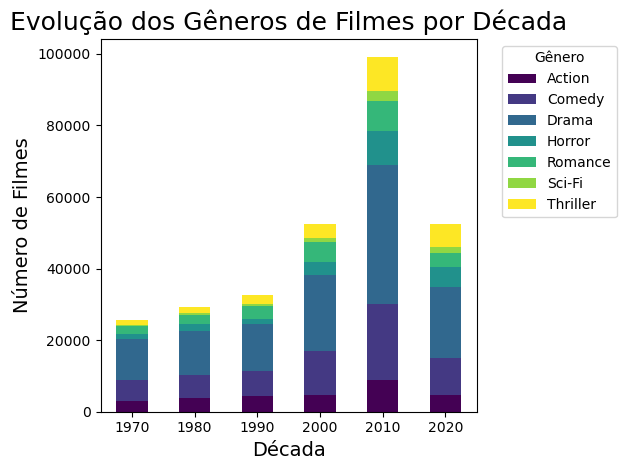

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


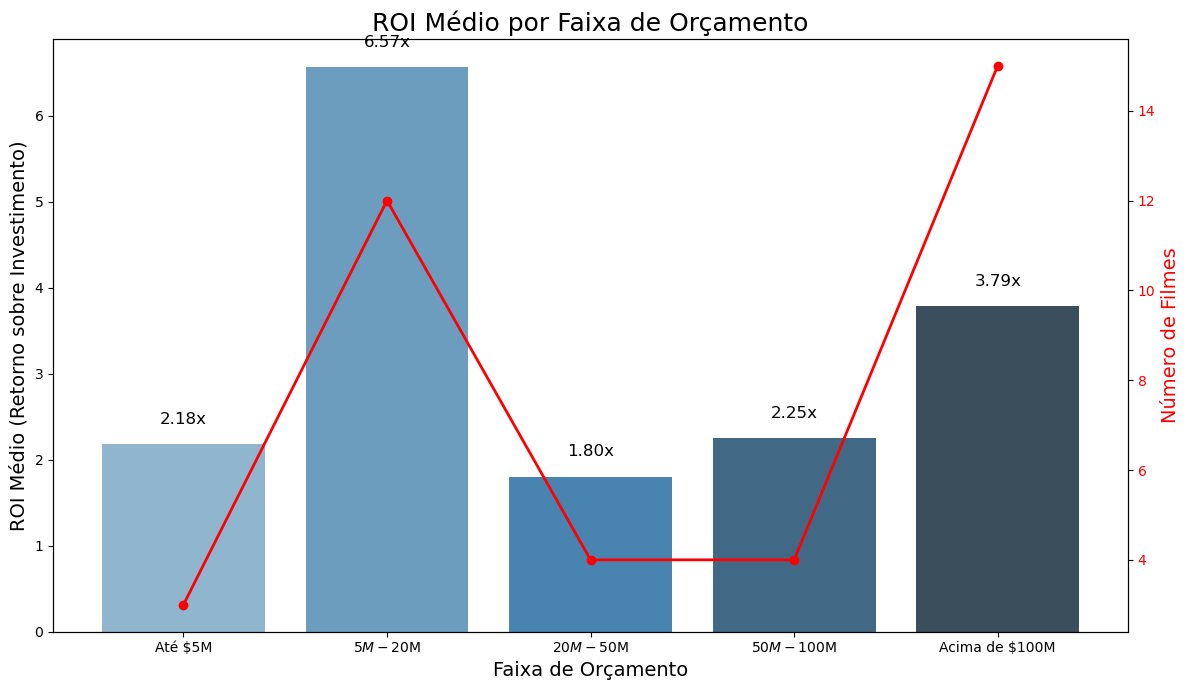


Criando visualização de evolução da duração dos filmes...


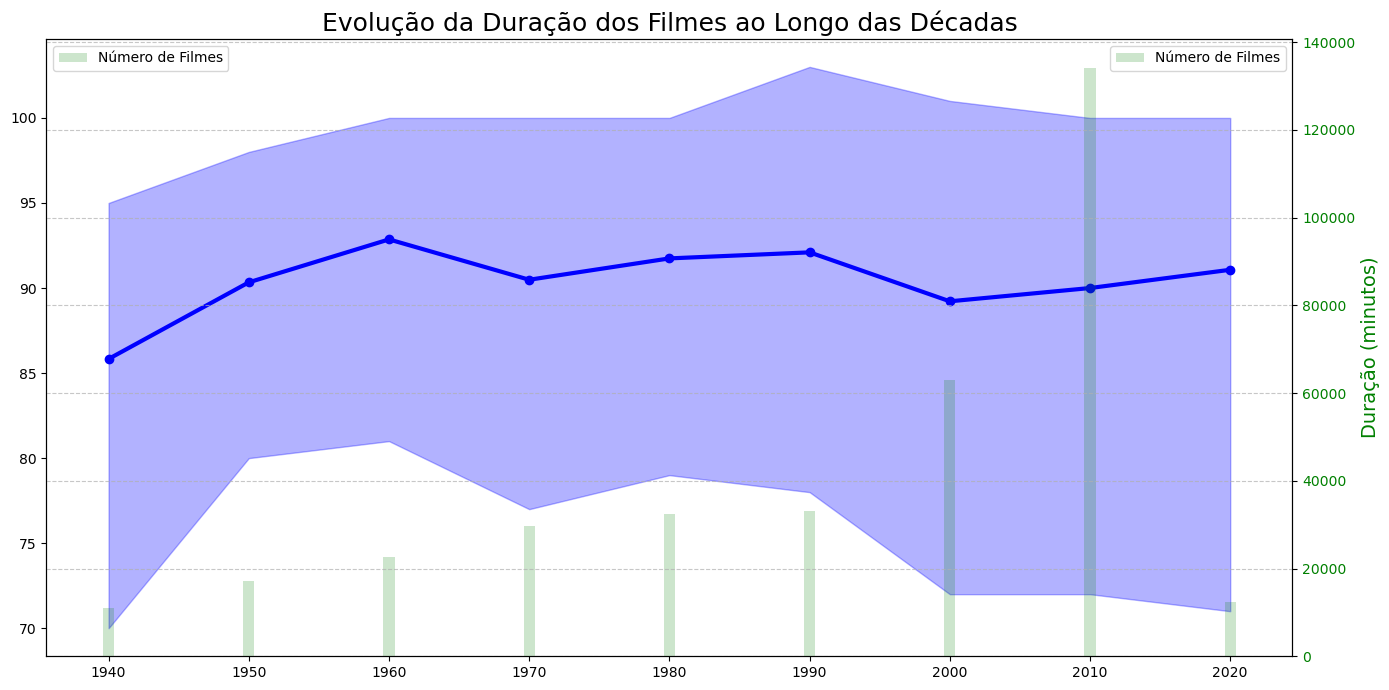


Criando visualização de correlação entre avaliação e lucratividade...


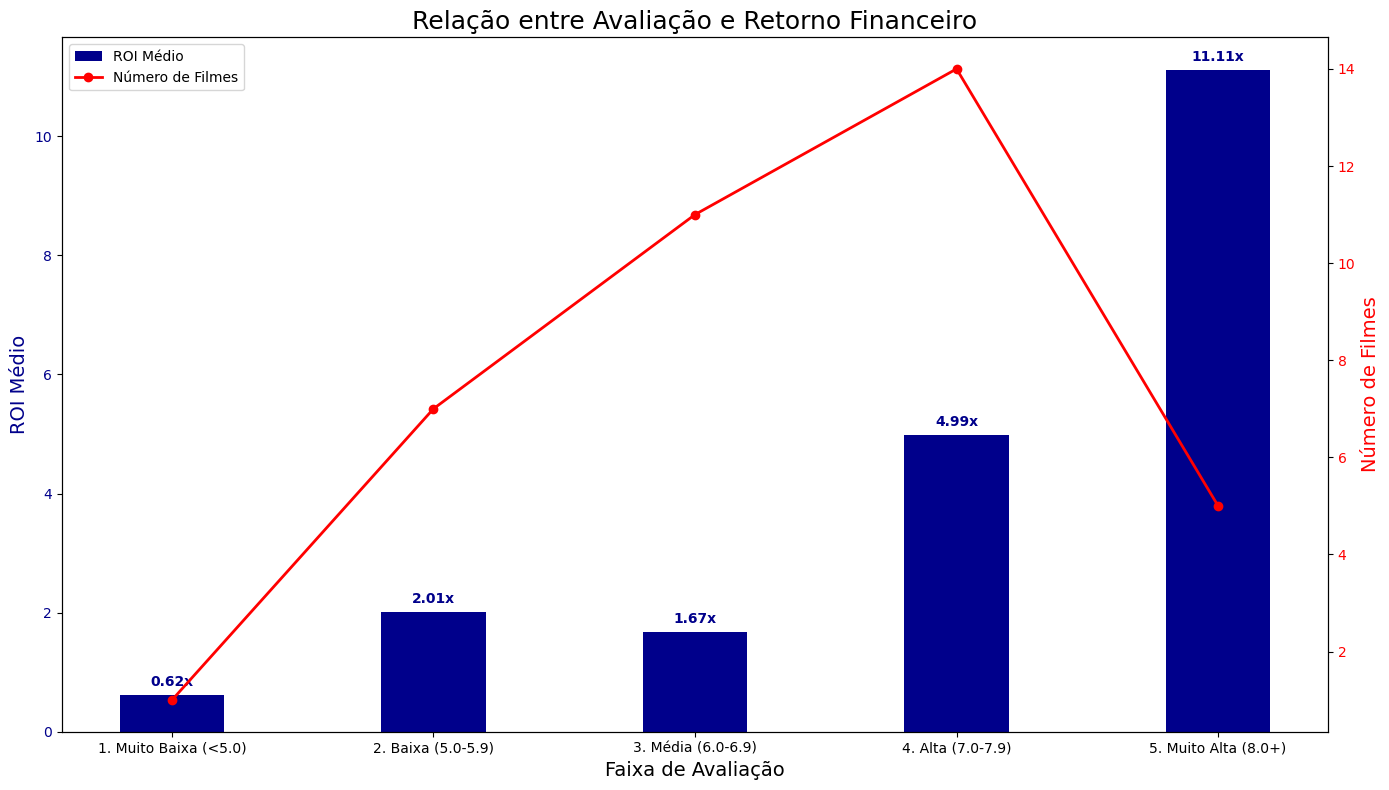

In [16]:
# Visualização 1: Evolução de gêneros populares ao longo das décadas
def plot_genre_evolution():
    print("\nCriando visualização de evolução de gêneros populares...")
    
    try:
        # Converter para pandas para visualização
        top_genres = ["Drama", "Comedy", "Action", "Thriller", "Romance", "Horror", "Sci-Fi"]
        
        # Construir a condição de filtro corretamente
        genre_filter = "genre IN ('" + "','".join(top_genres) + "')"
        
        genre_data = gold_genre_decade.filter(
            "decade >= 1970 AND decade <= 2020"
        ).filter(
            genre_filter
        ).toPandas()
        
        if len(genre_data) == 0:
            print("⚠️ Dados insuficientes para visualização.")
            return
        
        plt.figure(figsize=(14, 8))
        
        # Pivot para visualização
        genre_pivot = genre_data.pivot(index='decade', columns='genre', values='movie_count')
        genre_pivot.plot(kind='bar', stacked=True, colormap='viridis')
        
        plt.title('Evolução dos Gêneros de Filmes por Década', fontsize=18)
        plt.xlabel('Década', fontsize=14)
        plt.ylabel('Número de Filmes', fontsize=14)
        plt.xticks(rotation=0)
        plt.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        plt.show()
    
      
    except Exception as e:
        print(f"⚠️ Erro ao criar visualização: {str(e)}")

# Visualização 2: Relação entre orçamento e ROI
def plot_budget_vs_roi():
    print("\nCriando visualização de relação entre orçamento e ROI...")
    
    try:
        # Converter para pandas para visualização
        if gold_budget_revenue is not None:
            budget_roi_data = gold_budget_revenue.toPandas()
            
            if len(budget_roi_data) == 0:
                print("⚠️ Dados insuficientes para visualização.")
                return
            
            # Ordenar as categorias de orçamento corretamente
            order = ['Até $5M', '$5M-$20M', '$20M-$50M', '$50M-$100M', 'Acima de $100M']
            budget_roi_data['budget_range'] = pd.Categorical(
                budget_roi_data['budget_range'], 
                categories=order, 
                ordered=True
            )
            budget_roi_data = budget_roi_data.sort_values('budget_range')
            
            plt.figure(figsize=(12, 7))
            
            # Criar barras para ROI médio
            ax = sns.barplot(x='budget_range', y='avg_roi', data=budget_roi_data, palette='Blues_d')
            
            # Adicionar textos sobre as barras
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}x', 
                            (p.get_x() + p.get_width() / 2., p.get_height() + 0.2), 
                            ha = 'center', va = 'bottom',
                            fontsize=12)
            
            # Adicionar linha para o número de filmes (eixo secundário)
            ax2 = ax.twinx()
            ax2.plot(ax.get_xticks(), budget_roi_data['movie_count'], 'ro-', linewidth=2)
            ax2.set_ylabel('Número de Filmes', color='r', fontsize=14)
            ax2.tick_params(axis='y', labelcolor='r')
            
            plt.title('ROI Médio por Faixa de Orçamento', fontsize=18)
            ax.set_xlabel('Faixa de Orçamento', fontsize=14)
            ax.set_ylabel('ROI Médio (Retorno sobre Investimento)', fontsize=14)
            plt.xticks(rotation=0)
            
            plt.tight_layout()
            
            plt.show()
            
    except Exception as e:
        print(f"⚠️ Erro ao criar visualização: {str(e)}")

# Visualização 3: Duração dos filmes ao longo do tempo
def plot_runtime_evolution():
    print("\nCriando visualização de evolução da duração dos filmes...")
    
    try:
        runtime_data = gold_runtime.toPandas()
        
        if len(runtime_data) == 0:
            print("⚠️ Dados insuficientes para visualização.")
            return
        
        plt.figure(figsize=(14, 7))
        
        # Linha para duração média
        plt.plot(runtime_data['decade'], runtime_data['avg_runtime'], marker='o', linewidth=3, color='blue', label='Duração Média')
        
        # Área sombreada para o intervalo interquartil
        plt.fill_between(runtime_data['decade'], 
                         runtime_data['p25_runtime'], 
                         runtime_data['p75_runtime'], 
                         alpha=0.3, color='blue', label='Intervalo P25-P75')
        
        # Eixo secundário para número de filmes
        ax2 = plt.gca().twinx()
        ax2.bar(runtime_data['decade'], runtime_data['movie_count'], alpha=0.2, color='green', label='Número de Filmes')
        ax2.set_ylabel('Número de Filmes', color='green', fontsize=14)
        ax2.tick_params(axis='y', labelcolor='green')
        
        # Configurações do gráfico principal
        plt.title('Evolução da Duração dos Filmes ao Longo das Décadas', fontsize=18)
        plt.gca().set_xlabel('Década', fontsize=14)
        plt.gca().set_ylabel('Duração (minutos)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(runtime_data['decade'])
        
        # Criar as legendas corretamente
        legend1 = plt.legend(loc='upper left')  # Legenda do eixo principal
        ax2.legend(loc='upper right')          # Legenda do eixo secundário
        plt.gca().add_artist(legend1)          
        
        plt.tight_layout()
        plt.show()  

    except Exception as e:
        print(f"⚠️ Erro ao criar visualização: {str(e)}")

# Visualização 4: Correlação entre avaliação e lucratividade
def plot_rating_vs_profit():
    print("\nCriando visualização de correlação entre avaliação e lucratividade...")
    
    try:
        if gold_rating_financial is not None:
            rating_profit_data = gold_rating_financial.toPandas()
            
            if len(rating_profit_data) == 0:
                print("⚠️ Dados insuficientes para visualização.")
                return
            
            # Ordenar os dados corretamente
            rating_profit_data['rating_range'] = pd.Categorical(
                rating_profit_data['rating_range'],
                categories=sorted(rating_profit_data['rating_range']),
                ordered=True
            )
            rating_profit_data = rating_profit_data.sort_values('rating_range')
            
            fig, ax1 = plt.subplots(figsize=(14, 8))
            
            # Primeira barra: ROI médio
            x_pos = np.arange(len(rating_profit_data['rating_range']))
            bars1 = ax1.bar(x_pos, rating_profit_data['avg_roi'], 
                           width=0.4, label='ROI Médio', color='darkblue')
            
            # Definir os ticks explicitamente antes de definir os labels
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels(rating_profit_data['rating_range'], rotation=0)
            
            ax1.set_ylabel('ROI Médio', color='darkblue', fontsize=14)
            ax1.tick_params(axis='y', labelcolor='darkblue')
            
            # Adicionar valores nas barras
            for bar in bars1:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{height:.2f}x',
                       ha='center', va='bottom', color='darkblue', fontweight='bold')
            
            # Segundo eixo para número de filmes
            ax2 = ax1.twinx()
            # Criar linha pontilhada para o número de filmes
            ax2.plot(x_pos, rating_profit_data['movie_count'], 
                    'ro-', linewidth=2, label='Número de Filmes')
            ax2.set_ylabel('Número de Filmes', color='red', fontsize=14)
            ax2.tick_params(axis='y', labelcolor='red')
            
            # Título e configurações
            plt.title('Relação entre Avaliação e Retorno Financeiro', fontsize=18)
            ax1.set_xlabel('Faixa de Avaliação', fontsize=14)
            
            # Legenda combinada
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"⚠️ Erro ao criar visualização: {str(e)}")

# Executar visualizações
try:
    print("\n=== Visualizações e Insights ===")
    
    plot_genre_evolution()
    plot_budget_vs_roi()
    plot_runtime_evolution()
    plot_rating_vs_profit()
    
except Exception as e:
    print(f"⚠️ Erro ao criar visualizações: {str(e)}")
